In [1]:
import urllib.request
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle
import utils
import hard_debias as hd
import double_hard_debias as dhd
from weat import weat
import analogy_tasks as ana
import further_embeddings as data # takes a while because it loads all embedding datasets

successfully loaded hard_debias
successfully loaded double_hard_debias
successfully loaded utils
successfully loaded analogy_tasks
successfully loaded further_embeddings


In [2]:
# load the two debiased embeddings obtained by our implementation of Double-Hard Debias
file_1 = open('debiased_1/debiased_1.p', 'rb') # please unzip the .zip folders "debiased_1.zip" and "debiased_2.zip"
debiased_equal = pickle.load(file_1)
file_1.close()
file_2 = open('debiased_2/debiased_2.p', 'rb')
debiased_fem_male = pickle.load(file_2)
file_2.close()
# load the Double-Hard debiased embeddings obtained by Wang et al. (2020)
file_3 = open('glove_dhd.p', 'rb')
glove_dhd_wang = pickle.load(file_3)
file_3.close()

In [62]:
# preprocessing glove_dhd.p
embedding_dhd = list(glove_dhd_wang.values())
vocab_dhd = list(glove_dhd_wang.keys())
w2id_dhd = {w: i for i, w in enumerate(vocab_dhd)}

In [64]:
dict_embeddings = {'original GloVe': (data.embedding, data.vocab, data.w2id), 'Double-Hard-GloVe (Wang et al.)': (embedding_dhd, vocab_dhd, w2id_dhd), 
                   'debiased_equal': (debiased_equal, data.vocab, data.w2id), 'debiased_fem_male': (debiased_fem_male, data.vocab, data.w2id),
                   'GN-Glove': (data.embedding_gn, data.vocab_gn, data.w2id_gn), 'GN-Glove(a)': (data.embedding_gn_a, data.vocab_gn_a, data.w2id_gn_a),
                   'GP-GloVe': (data.embedding_gp, data.vocab_gp, data.w2id_gp), 'GP-GN-GloVe': (data.embedding_gp_gn, data.vocab_gp_gn, data.w2id_gp_gn),
                   'Hard-GloVe': (data.embedding_hd, data.vocab_hd, data.w2id_hd), 'Strong-Hard-GloVe': (data.embedding_hd_a, data.vocab_hd_a, data.w2id_hd_a)
                  }

## Word Embedding Association Test
The Word Embedding Associatin Test (short WEAT) was introduced by [Caliskan, Bryson and Narayanan (2017)](https://arxiv.org/abs/1608.07187). It is a permutation test. Lower effect sizes `d` indicate less gender bias and p-values `p>0.05` indicate that the bias is insignificant. The word lists are taken from the original paper. The implementation is taken from https://github.com/shivaomrani/HumanBiasInSemantics with minor adjustments such as variable names for readability. See file `weat.py`.

In [5]:
# Career and family
# Change from Bill to Tom as in paper to avoid ambiguity
male_names = ["john", "paul", "mike", "kevin", "steve", "greg", "jeff", "tom"]
female_names = ["amy", "joan", "lisa", "sarah", "diana", "kate", "ann", "donna"]
career_attributes = ["executive", "management", "professional", "corporation", "salary", "office", "business", "career"]
family_attributes = ["home", "parents", "children", "family", "cousins", "marriage", "wedding", "relatives"]

In [6]:
# Math and arts
math_words = ["math", "algebra", "geometry", "calculus", "equations", "computation", "numbers", "addition"]
arts_words1 = ["poetry", "art", "dance", "literature", "novel", "symphony", "drama", "sculpture"]
male_attributes1 = ["male", "man", "boy", "brother", "he", "him", "his", "son"]
female_attributes1 = ["female", "woman", "girl", "sister", "she", "her", "hers", "daughter"]

In [7]:
# Science and arts
science_words = ["science", "technology", "physics", "chemistry", "einstein", "nasa", "experiment", "astronomy"]
arts_words2 = ["poetry", "art", "shakespeare", "dance", "literature", "novel", "symphony", "drama"]
male_attributes2 = ["brother", "father", "uncle", "grandfather", "son", "he", "his", "him"]
female_attributes2 = ["sister", "mother", "aunt", "grandmother", "daughter", "she", "hers", "her"]

In [9]:
concept1 = [male_names, math_words, science_words]
concept2 = [female_names, arts_words1, arts_words2]
stereotype1 = [career_attributes, male_attributes1, male_attributes2]
stereotype2 = [family_attributes, female_attributes1, female_attributes2]
column_names = ["C & F: d", "C & F: p", "M & A: d", "M & A: p", "S & A: d", "S & A: p"]

iterations=100000
test_results = []

# apply weat test to each embedding
for key, (embedding, vocab, w2id) in dict_embeddings.items():
    result = []
    print(key + ":")
    for i in range(3): # do three tests (Career&Family, Math&Arts, Science&Arts)
        wea_test = weat(concept1[i], concept2[i], stereotype1[i], stereotype2[i], iterations, embedding, w2id)
        pvalue, effect_size, _ = wea_test.getPValueAndEffect()
        result.append(effect_size)
        result.append(pvalue)
    test_results.append(result)
    print()
    
test_results = np.array(test_results).astype(float)
results_WEAT = pd.DataFrame(data = test_results, index = list(dict_embeddings.keys()), columns = column_names)
results_WEAT

original GloVe:
The difference of means is  0.144274442398455
Generating null distribution...
Number of permutations  100000
Getting the entire distribution
The difference of means is  0.01738401491456898
Generating null distribution...
Number of permutations  100000
Getting the entire distribution
The difference of means is  0.031252209897502325
Generating null distribution...
Number of permutations  100000
Getting the entire distribution

Double-Hard-GloVe (Wang et al.):
The difference of means is  0.06302389644450046
Generating null distribution...
Number of permutations  100000
Getting the entire distribution
The difference of means is  -0.005243868700536593
Generating null distribution...
Number of permutations  100000
Getting the entire distribution
The difference of means is  -0.011068363782534632
Generating null distribution...
Number of permutations  100000
Getting the entire distribution

debiased_equal:
The difference of means is  0.07432800979548916
Generating null distribu

,C & F: d,C & F: p,M & A: d,M & A: p,S & A: d,S & A: p
original GloVe,1.805996,0.000156,0.688595,0.084282,1.129869,0.012169
Double-Hard-GloVe (Wang et al.),1.531301,0.001082,-0.562549,0.869671,-0.650270,0.902739
debiased_equal,1.541464,0.001058,-0.643900,0.901842,-0.777509,0.941027
debiased_fem_male,1.517982,0.001233,-0.275041,0.709058,-0.293396,0.722552
GN-Glove,1.821105,0.000136,-0.256358,0.695403,1.068954,0.016210
GN-Glove(a),1.755476,0.000224,0.503003,0.157361,0.879733,0.039488
GP-GloVe,1.805885,0.000155,1.208529,0.007865,1.106440,0.013674
GP-GN-GloVe,1.797431,0.000164,-0.012642,0.511331,0.846007,0.045834
Hard-GloVe,1.546646,0.000965,-0.982604,0.975247,-0.538376,0.860529
Strong-Hard-GloVe,1.546646,0.001012,-0.985681,0.975565,-0.547118,0.863181


## Neighborhood Metric
The neighborhood metric was introduced by [Gonen & Goldberg (2019)](https://arxiv.org/abs/1903.03862) and it is based on clustering. An accuracy value close to 0.5 indicates less biased word embeddings. Wang et al. (2020) also used the neighborhood metric in their Double-Hard Debias algorithm.

In [15]:
# first, get the female and male biased word sets (on the original GloVe embedding):
gender_subspace = hd.idtfy_gender_subspace(data.embedding, data.vocab, data.w2id, data.definitional_pairs)


# get the Top 1000 biased female and male words
f_biased_1000, m_biased_1000 = utils.get_most_biased(data.embedding, data.vocab, gender_subspace, k=1000)

# Top 500
f_biased_500, m_biased_500 = f_biased_1000[:500], m_biased_1000[:500]

# Top 100 
f_biased_100, m_biased_100 = f_biased_1000[:100], m_biased_1000[:100]

In [16]:
# get embeddings for the Top 100 female and male biased words for each embedding dataset
female_biased_100, male_biased_100 = utils.get_embeddings(dict_embeddings, f_biased_100, m_biased_100)

# Top 500
female_biased_500, male_biased_500 = utils.get_embeddings(dict_embeddings, f_biased_500, m_biased_500)
    
# Top 1000
female_biased_1000, male_biased_1000 = utils.get_embeddings(dict_embeddings, f_biased_1000, m_biased_1000)

In [18]:
# compute Neighborhood Metric for each embedding
accuracies_100 = utils.compute_NM(female_biased_100, male_biased_100)

accuracies_500 = utils.compute_NM(female_biased_500, male_biased_500)
# perform t-SNE on female and male biased embeddings
tsne_results = {}
for key, fem_embs in female_biased_500.items():
    male_embs = male_biased_500[key]
    tsne_fem = TSNE(n_components = 2).fit_transform(np.asarray(fem_embs)) # embedded space should have two dimensions
    tsne_male = TSNE(n_components = 2).fit_transform(np.asarray(male_embs))
    tsne_results[key] = (tsne_fem, tsne_male)
    
accuracies_1000 = utils.compute_NM(female_biased_1000, male_biased_1000)

In [27]:
# put all data in one list for pd dataframe
accuracies = []
for key in dict_embeddings.keys():
    accuracies.append(accuracies_100[key])
    accuracies.append(accuracies_500[key])
    accuracies.append(accuracies_100[key])
accuracies = np.asarray(accuracies).reshape(10, 3)
results_NM = pd.DataFrame(data = accuracies, index = list(dict_embeddings.keys()), columns = ["Top 100", "Top 500", "Top 1000"])
results_NM

,Top 100,Top 500,Top 1000
original GloVe,1.0000,1.0000,1.0000
Double-Hard-GloVe (Wang et al.),0.7250,0.7805,0.7250
debiased_equal,0.7375,0.7635,0.7375
debiased_fem_male,0.7150,0.8065,0.7150
GN-Glove,1.0000,0.5005,1.0000
GN-Glove(a),1.0000,0.5015,1.0000
GP-GloVe,0.5000,1.0000,0.5000
GP-GN-GloVe,0.5000,0.9990,0.5000
Hard-GloVe,0.7450,0.7565,0.7450
Strong-Hard-GloVe,0.7575,0.7590,0.7575


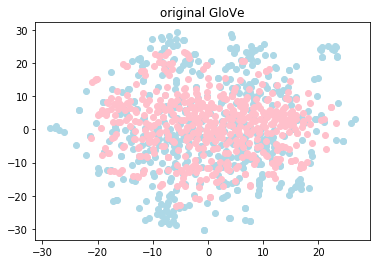

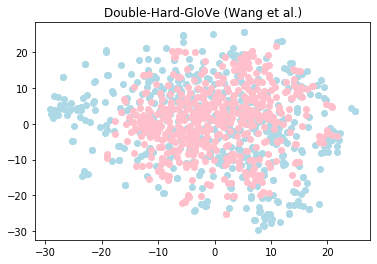

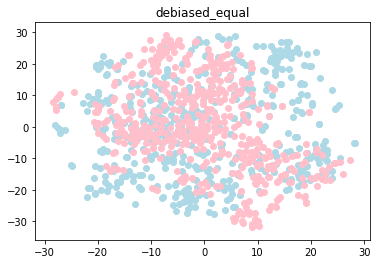

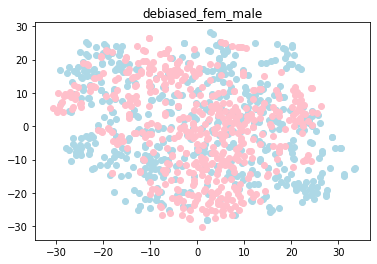

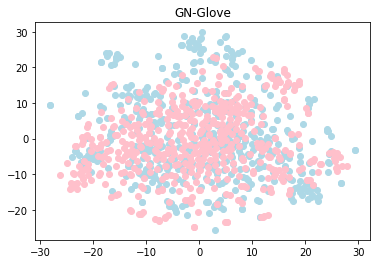

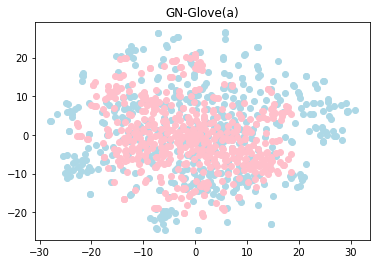

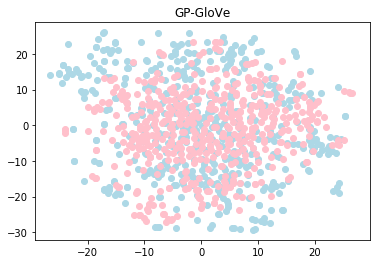

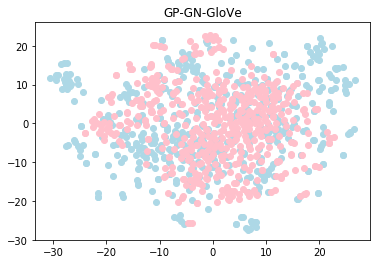

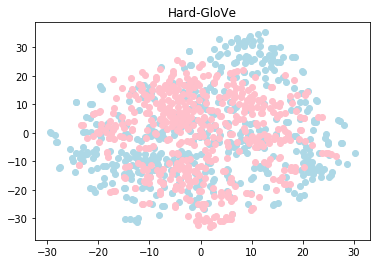

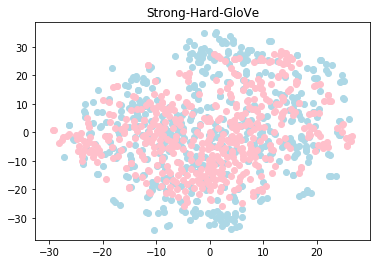

In [38]:
for key, values in tsne_results.items():
    fig, ax = plt.subplots(1)
    ax.set_title(key)
    (tsne_fem, tsne_male) = values
    ax.scatter(x = tsne_fem[:,0], y = tsne_fem[:,1], color='lightblue')
    ax.scatter(x = tsne_male[:,0], y = tsne_male[:,1], color='pink')
plt.show()

## Word Analogy
The word analogy task is to find a word *D* such that "*A* is to *B* as *C* is to *D*". Wang et al. (2020) have evaluated all non-debiased and debiased embeddings on the MSR word analogy task [Mikolov et al., 2013a](https://www.aclweb.org/anthology/N13-1090/) as well as on a second Google word analogy dataset [Mikolov et al. 2013b](https://arxiv.org/abs/1301.3781v3). The evaluation metric is the percentage of questions for which the correct answer is assigned the maximum score by the algorithm. The analogy task is used to show whether a debiasing method is capable of preserving desired distance relations between words. The implementation was taken from Wang et al. (2020) with some adjustments to get it running: `analogy_tasks.py`

### MSR

In [65]:
# delete embedding
del dict_embeddings['Double-Hard-GloVe (Wang et al.)']

In [66]:
# MSR on all embeddings:
for key, (embedding, vocab, w2id) in dict_embeddings.items():
    print(key + ":")
    ana.evaluate_analogy_msr(embedding, vocab, w2id)
    print()

original GloVe:
4884
ACCURACY TOP1-MSR: 54.40% (2657/4884)

debiased_equal:
4884
ACCURACY TOP1-MSR: 62.59% (3057/4884)

debiased_fem_male:
4884
ACCURACY TOP1-MSR: 61.59% (3008/4884)

GN-Glove:
4884
ACCURACY TOP1-MSR: 51.72% (2526/4884)

GN-Glove(a):
4884
ACCURACY TOP1-MSR: 50.72% (2477/4884)

GP-GloVe:
4884
ACCURACY TOP1-MSR: 51.62% (2521/4884)

GP-GN-GloVe:
4884
ACCURACY TOP1-MSR: 51.99% (2539/4884)

Hard-GloVe:
4884
ACCURACY TOP1-MSR: 62.57% (3056/4884)

Strong-Hard-GloVe:
4884
ACCURACY TOP1-MSR: 62.14% (3035/4884)



In [67]:
# Google analogy task on all embeddings:
for key, (embedding, vocab, w2id) in dict_embeddings.items():
    print(key + ":\n")
    ana.evaluate_analogy_google(embedding, vocab, w2id)
    print("\n")

original GloVe:

capital-common-countries.txt:
ACCURACY TOP1: 98.95% (283/286)
capital-world.txt:
ACCURACY TOP1: 94.69% (1409/1488)
currency.txt:
ACCURACY TOP1: 7.63% (18/236)
city-in-state.txt:
ACCURACY TOP1: 77.49% (1855/2394)
family.txt:
ACCURACY TOP1: 71.67% (301/420)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 9.25% (86/930)
gram2-opposite.txt:
ACCURACY TOP1: 29.22% (135/462)
gram3-comparative.txt:
ACCURACY TOP1: 78.68% (1048/1332)
gram4-superlative.txt:
ACCURACY TOP1: 46.55% (378/812)
gram5-present-participle.txt:
ACCURACY TOP1: 47.42% (441/930)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 93.23% (1418/1521)
gram7-past-tense.txt:
ACCURACY TOP1: 34.87% (544/1560)
gram8-plural.txt:
ACCURACY TOP1: 75.46% (898/1190)
gram9-plural-verbs.txt:
ACCURACY TOP1: 45.57% (370/812)
Questions seen/total: 73.54% (14373/19544)
Semantic accuracy: 80.14%  (3866/4824)
Syntactic accuracy: 55.69%  (5318/9549)
Total accuracy: 63.90%  (9184/14373)


debiased_equal:

capital-common-countries.txt:
ACC